### Einleitung 

**Im Folgenden betrachten wir den Goodreads-Datensatz https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks. 
Dieser enthält verschiedene Informationen zu Büchern wie den Buchtitel, die Anzahl der Seiten und Bewertungen etc.
Unser Ziel ist es, den Datensatz kennenzulernen und einige Fragen zu beantworten, wie zum Beispiel:\
Welche Bücher wurden am häufigsten bewertet?\
Welche Sprache wird am meisten genutzt?\
Wie sind die durchschnittlichen Bewertungen und die Anzahl der Seiten verteilt?\
Was sind die Beziehungen zwischen den einzelnen Faktoren?\
Anschließend empfehlen wir mithilfe des KNN-Algorithmus Bücher, die dem Nutzer gefallen könnten, basierend auf einem Buchtitel.**

### Imports

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("books.csv", error_bad_lines = False)
df.head()

Skipping line 3350: expected 12 fields, saw 13
Skipping line 4704: expected 12 fields, saw 13
Skipping line 5879: expected 12 fields, saw 13
Skipping line 8981: expected 12 fields, saw 13



,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


Der Datensatz besteht aus folgenden Variabeln:

bookID: Id für jeweiliges Buch\
title: Titel des Buchs\
authors: Autor des Buches\
average_rating: Durchschnitliche Buch Bewertung (0-5) \
isbn: ISBN10\
isbn13: ISBN 13 \
language_code: Sprache in welcher das Buch verfasst wurde\
Num_pages: Anzahl der Seiten\
Ratings_count: Anzahl der Bewertungen (Zahl)\
text_reviews_count: Anzahl der Bewertungen (Schrift) \
publication_date: Veröffentlichkeitsdatum \
publisher: Verlag


### Data cleaning

In [77]:
df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [78]:
df.duplicated().any()

False

Es fehlen keine Werte. Zur Identifikation eines Buches verwenden wir ausschließlich die ISBN13-Nummer. Außerdem ändern wir das Datumsformat.

In [79]:
df.drop(['bookID','isbn'],axis=1, inplace=True)
df["publication_date"]=df.publication_date.apply(lambda x: int(str(x).split("/")[2]))

### Explorative Datananalyse 

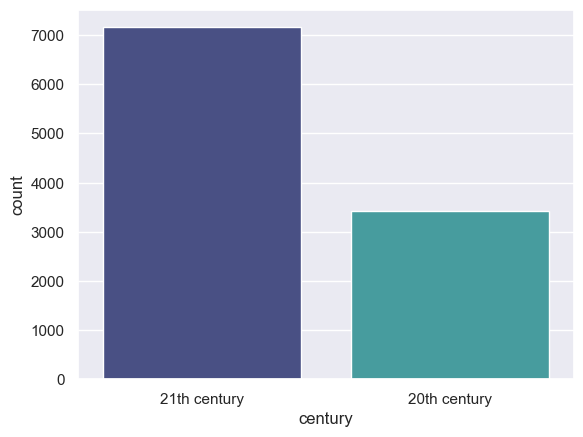

In [108]:
def century(x):
    if x > 2000:
        return "21th century"
    if 1900 < x < 2000:
        return "20th century"
    else:
        "19th century"
df["century"]=df.publication_date.apply(century)
sns.countplot(data=df,x="century",palette = "mako")
plt.show()

**Die 20 meist bewerteten Bücher**

<Axes: xlabel='ratings_count', ylabel='title'>

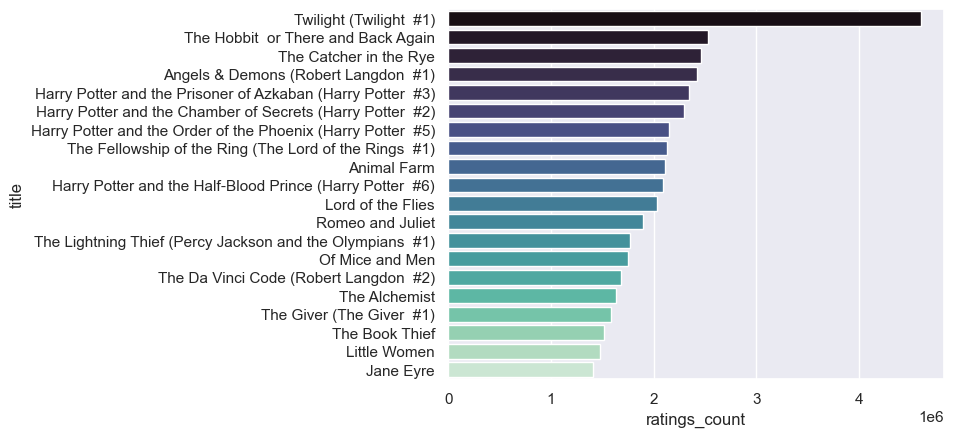

In [106]:
meistbewertet = df.sort_values('ratings_count',ascending=False).head(20)
sns.barplot(meistbewertet,x = meistbewertet['ratings_count'],y = meistbewertet['title'],palette = "mako")

**Die 20 meist kommentierten Bücher** 

<Axes: xlabel='text_reviews_count', ylabel='title'>

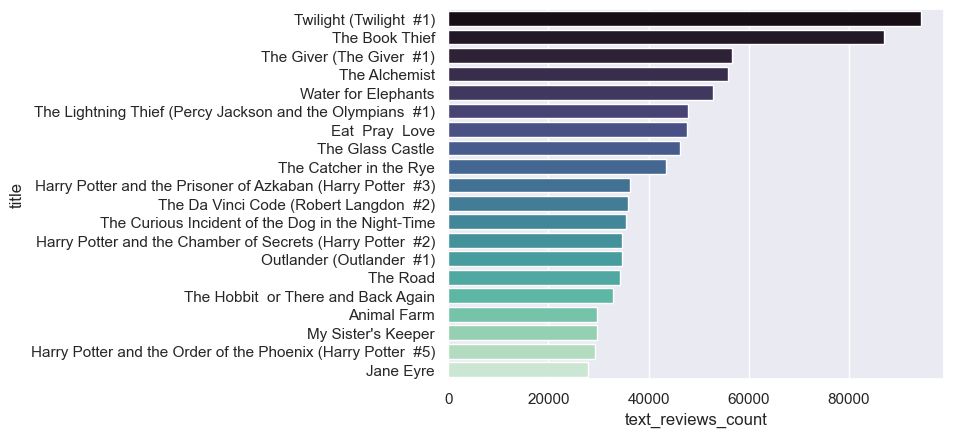

In [107]:
bestewertet = df.sort_values('text_reviews_count',ascending=False).head(20)
sns.barplot(bestewertet,x = bestewertet['text_reviews_count'],y = bestewertet['title'],palette = "mako" )

**Die meist genutzten Sprachen**

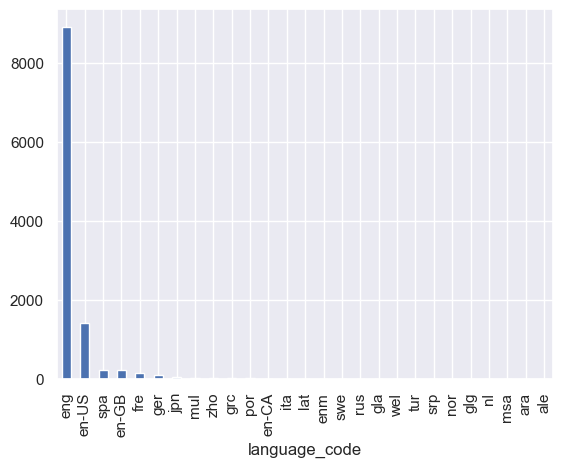

In [83]:
sprache = df.groupby(['language_code'])['title'].count().sort_values(ascending = False).plot(kind = 'bar')


Die meist genutze Sprache ist Englisch. Zu Bemerken ist das die ersten beiden Sprachen Englisch sind.

**Durschnitliches Rating und Seiten Zahl**

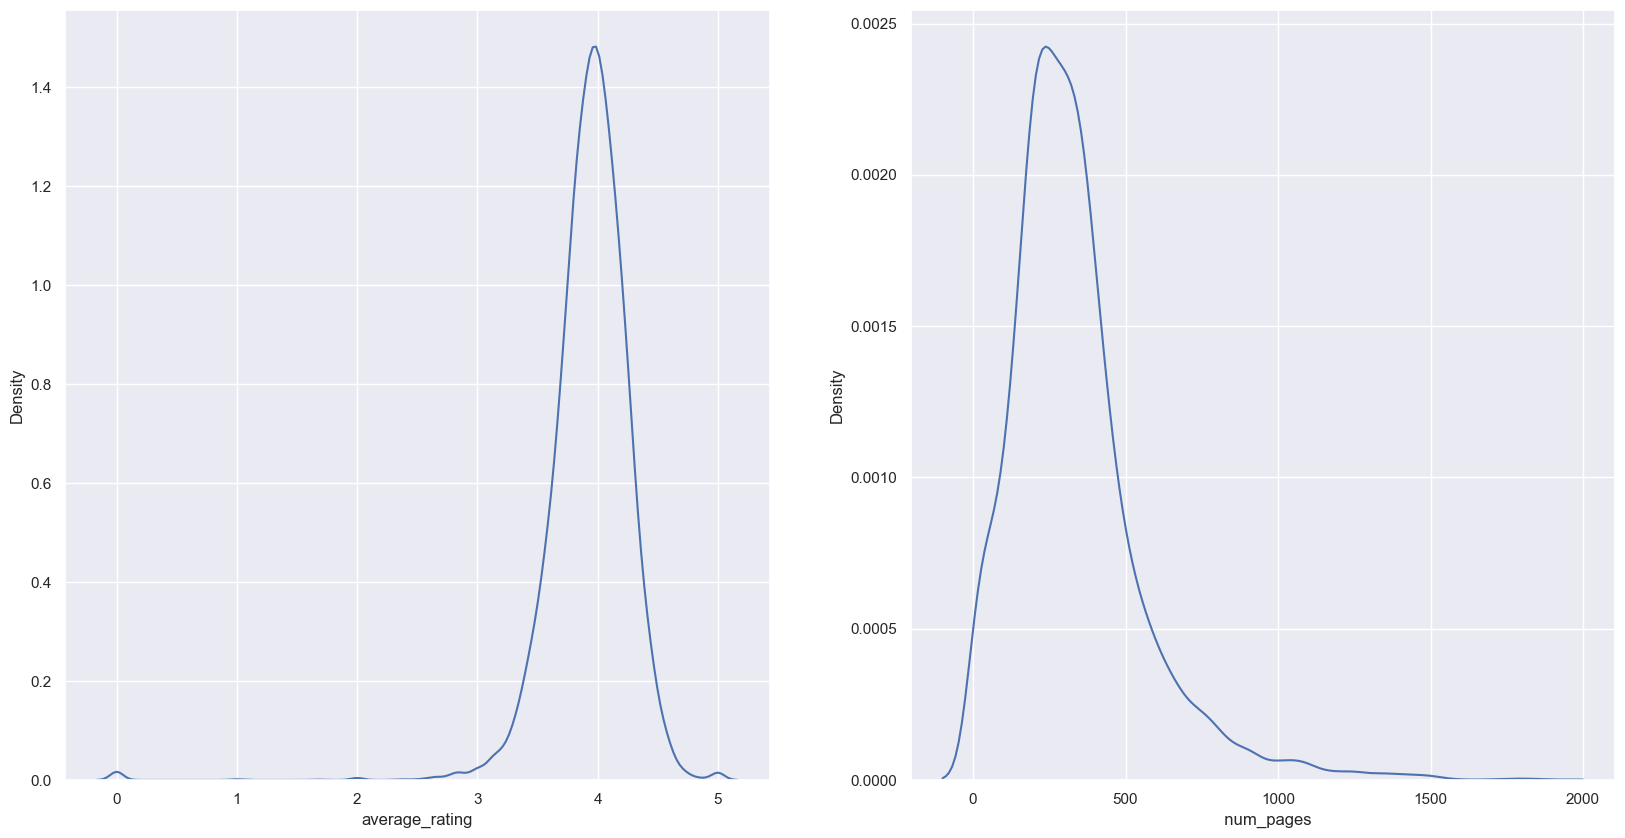

In [84]:
fig, ax =plt.subplots(1,2,figsize=(20,10))
sns.kdeplot(df['average_rating'],ax = ax[0])
sns.kdeplot(df['  num_pages'],ax = ax[1], clip=(-100, 2000))
fig.show()

Der Mittelwert der Durchschnittlichen Bewertungen ist: 

In [85]:
df.loc[:,'average_rating'].mean()

3.9340753393868564

Für die Seitenanzahl ergibt sich:

In [86]:
df.loc[:,'  num_pages'].mean()

336.4055560550211

### Buch Empfehlung mit KNN

Unser Ziel ist es, Buchempfehlungen auf Basis eines gegebenen Buches zu erstellen. Hierfür nutzen wir den k-Nearest-Neighbors-Algorithmus. Zunächst betrachten wir die Beziehung zwischen den einzelnen Merkmalen. 

Wir betrachten die folgenden Features: average_rating, language_code, num_pages, ratings_count, text_reviews_count. Da es einige Ausreißer gibt, begrenzen wir den Sichtbereich.

Average Rating:

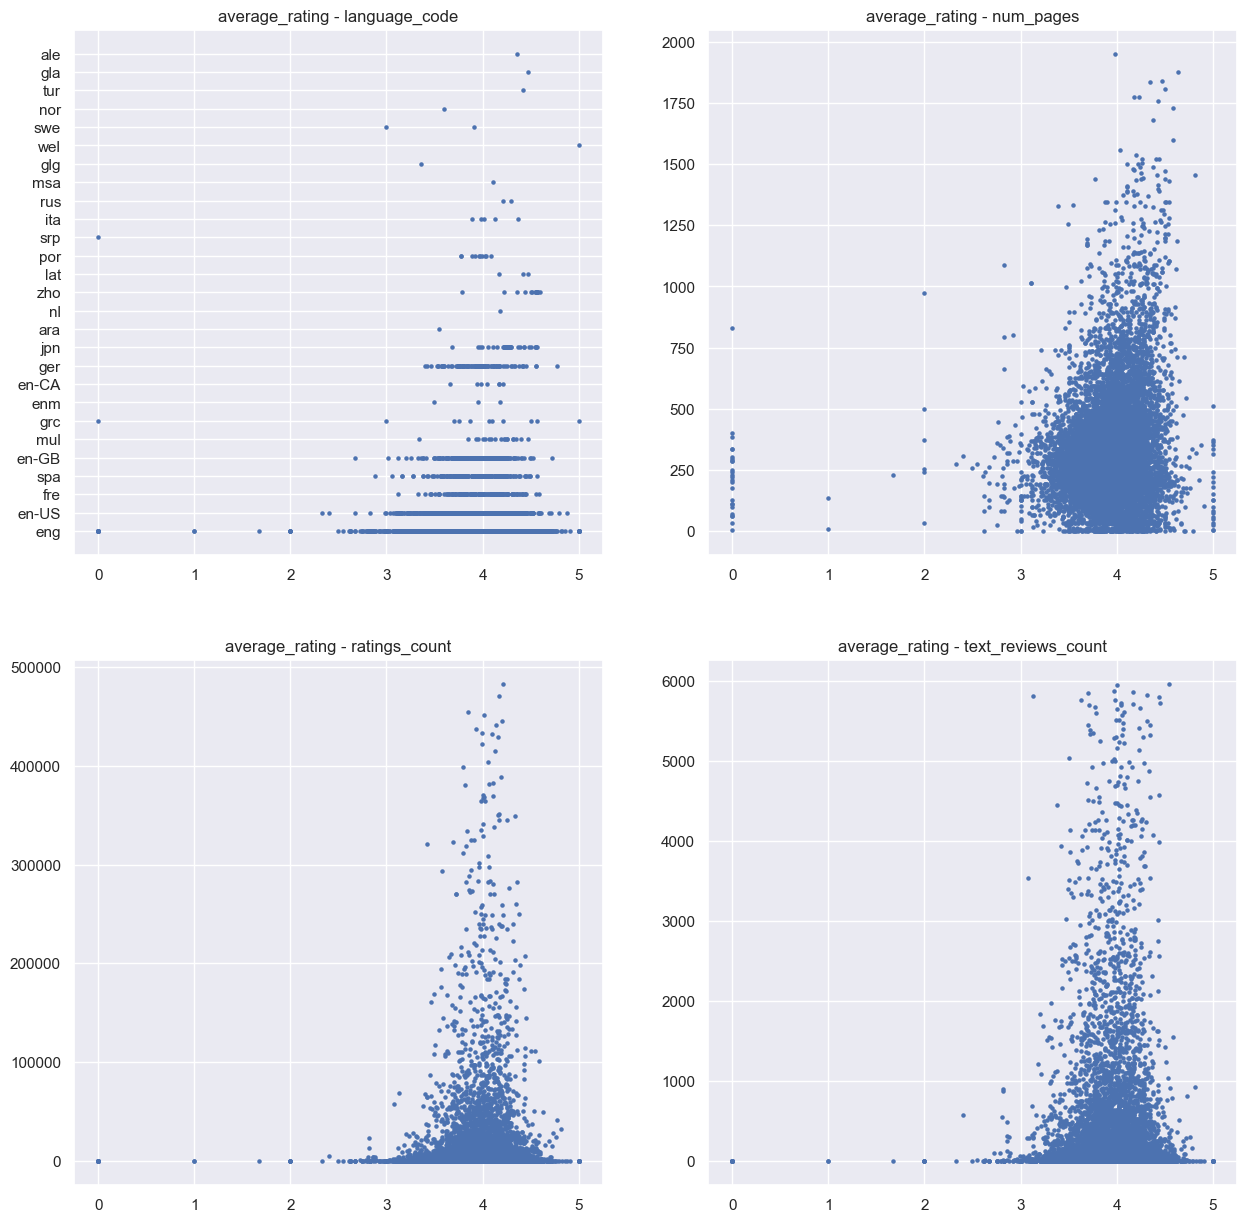

In [111]:
fig,axes =plt.subplots(2,2,figsize=(15,15))
axes[0,0].scatter(data=df, x="average_rating", y="language_code", marker='o',s = 5)
axes[0,1].scatter(data=df[~(df["  num_pages"]>2000)], x="average_rating", y="  num_pages", marker='o',s = 5)
axes[1,0].scatter(data=df[~(df['ratings_count']>500000)], x="average_rating", y="ratings_count", marker='o',s = 5)
axes[1,1].scatter(data=df[~(df['text_reviews_count']>6000)], x="average_rating", y="text_reviews_count", marker='o',s = 5)
axes[0,0].title.set_text('average_rating - language_code')
axes[0,1].title.set_text('average_rating - num_pages')
axes[1,0].title.set_text('average_rating - ratings_count')
axes[1,1].title.set_text('average_rating - text_reviews_count')

Rating Count:

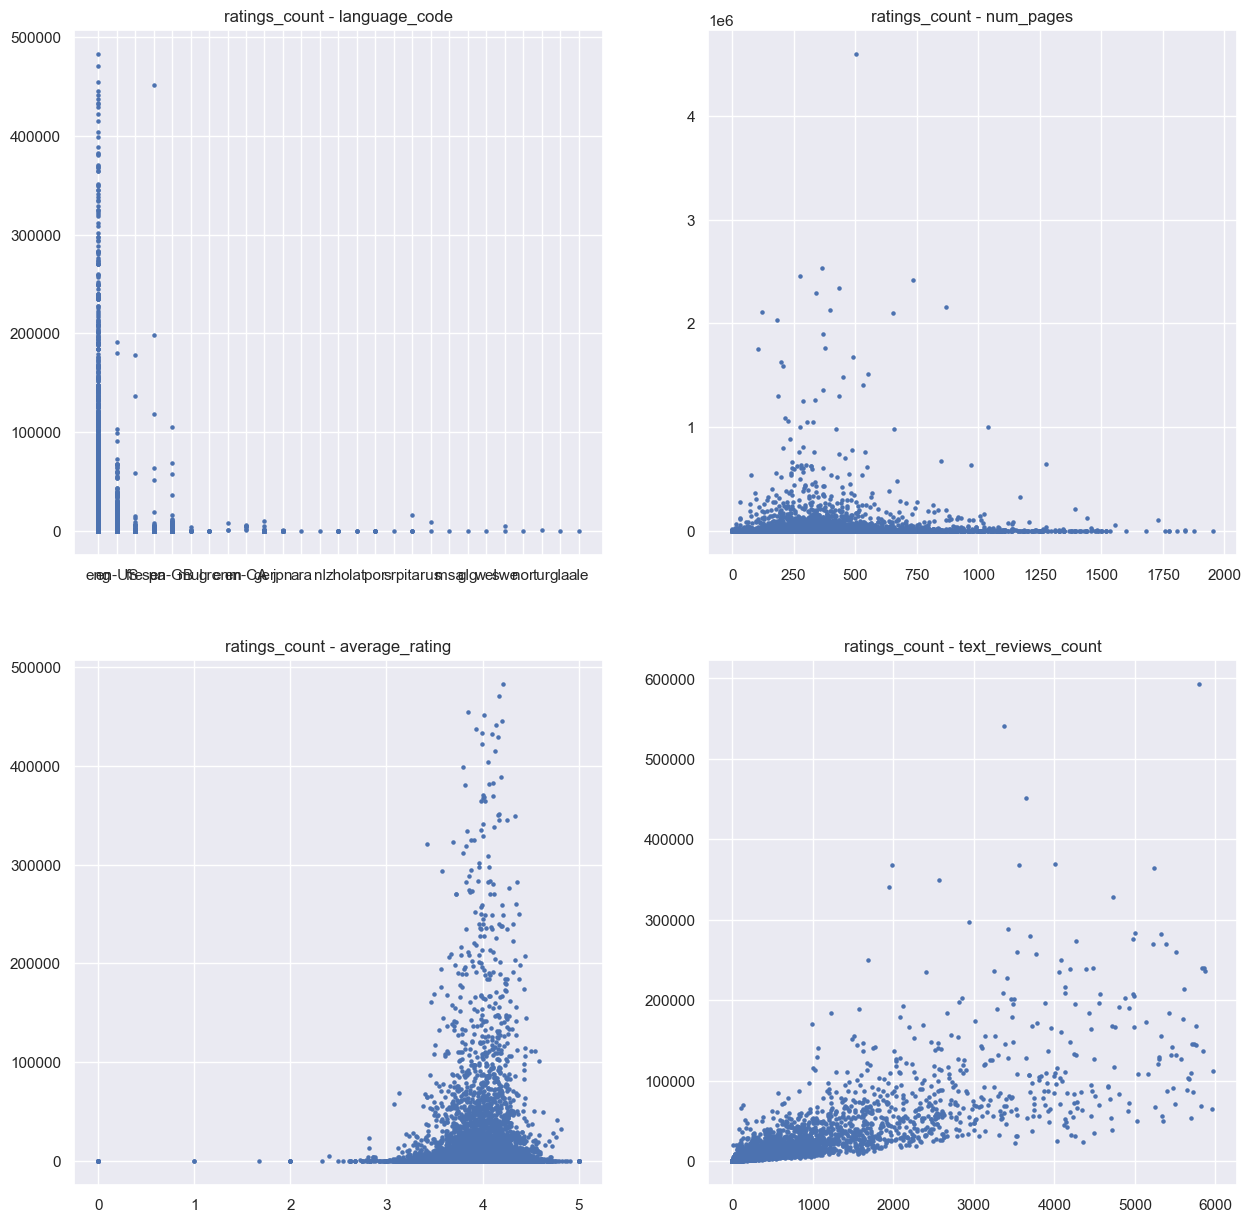

In [113]:
fig,axes =plt.subplots(2,2,figsize=(15,15))
axes[0,0].scatter(data=df[~(df['ratings_count']>500000)], y="ratings_count", x="language_code", marker='o',s = 5)
axes[0,1].scatter(data=df[~(df["  num_pages"]>2000)], y="ratings_count", x="  num_pages", marker='o',s = 5)
axes[1,0].scatter(data=df[~(df['ratings_count']>500000)], y="ratings_count", x="average_rating", marker='o',s = 5)
axes[1,1].scatter(data=df[~(df["text_reviews_count"]>6000)], y="ratings_count", x="text_reviews_count", marker='o',s = 5)
axes[0,0].title.set_text('ratings_count - language_code')
axes[0,1].title.set_text('ratings_count - num_pages')
axes[1,0].title.set_text('ratings_count - average_rating')
axes[1,1].title.set_text('ratings_count - text_reviews_count')

**Ergebnis:** 
- Mit zunehmender Anzahl an Bewertungen scheint die Durchschnitliche Bewertung sich der 4 zu nähern.
- Die meisten Bewertungen liegen für Bücher mit ein Wertung zwischen 3.5 und 4.5 vor.
- Bücher mit 150 bis 400 Seiten scheinen besonder beliebt zu sein
- Eine Verbindung zwischen Sprache und Durchschnitliche Bewertung scheint es nicht zu geben.

**Für unser Model betrachten wir die Variabeln average_rating, ratings_count und language_code.**

In [89]:
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Wie viele Kluster?\
Wir berechnen für $k = 2,...,20$ die Quadrierte Summe der Entfernungen zum nächsten Centroiden. 

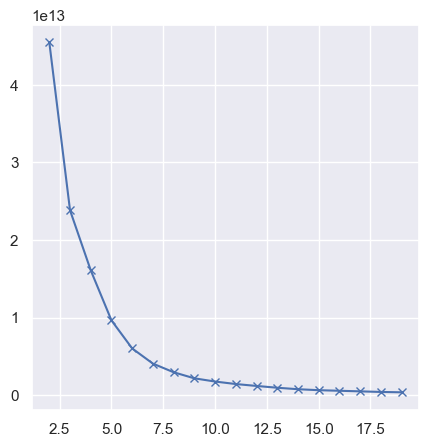

In [90]:
trial = df[['average_rating', 'ratings_count']]
data = np.asarray([np.asarray(trial['average_rating']), np.asarray(trial['ratings_count'])]).T

abstand = []
for k in range(2,20):
    k_means = KMeans(n_clusters = k)
    k_means.fit(data)
    abstand.append(k_means.inertia_)

fig = plt.figure(figsize=(5,5))
plt.plot(range(2,20), abstand, 'bx-')


Ab $k = 7$ flacht die Kurve ab, somit erreichnen wir ab hier mit mehr Clustern keine signifikant besseren Egebnisse.


In [91]:
#Kategoriale Variablen änderen 
language_df = pd.get_dummies(df['language_code'])

features = pd.concat([language_df, df['average_rating'], df['ratings_count']], axis=1)

from sklearn.preprocessing import MinMaxScaler
#Da für manche Bücher die Werte im Vergleich zum Rest sehr groß sind, skalieren wir Sie. 
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

model = neighbors.NearestNeighbors(n_neighbors=7)
model.fit(features)
#Liste mit Nachbarn zu jedem Buch
_ , ids = model.kneighbors(features)

In [92]:
def book(book_name):
    name_list = []
    book_id = df[df['title'] == book_name].index
    for newid in ids[book_id[0]]:
        name_list.append(df.loc[newid].title)
    return name_list

**Hier einige Beispiele:**

In [93]:
recommended_books = book("The Lightning Thief (Percy Jackson and the Olympians  #1)")
recommended_books

['The Lightning Thief (Percy Jackson and the Olympians  #1)',
 'The Giver (The Giver  #1)',
 'The Book Thief',
 'Little Women',
 'Of Mice and Men',
 'The Fellowship of the Ring (The Lord of the Rings  #1)',
 'Jane Eyre']

In [94]:
recommended_books = book("The Great Gatsby")
recommended_books

['The Great Gatsby',
 'The Philadelphia Adventure',
 'The Great World',
 'Chemistry: The Central Science',
 'The Curious Incident of the Dog in the Night-Time',
 'Legends 2 (Legends 1  Volume 2of3)',
 'Sailing from Byzantium: How a Lost Empire Shaped the World']

In [95]:
recommended_books = book("Harry Potter and the Order of the Phoenix (Harry Potter  #5)")
recommended_books

['Harry Potter and the Order of the Phoenix (Harry Potter  #5)',
 'Harry Potter and the Half-Blood Prince (Harry Potter  #6)',
 'The Fellowship of the Ring (The Lord of the Rings  #1)',
 'Harry Potter and the Chamber of Secrets (Harry Potter  #2)',
 'Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)',
 'The Hobbit  or There and Back Again',
 'The Lightning Thief (Percy Jackson and the Olympians  #1)']

 (License CC0: Public Domain)